## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

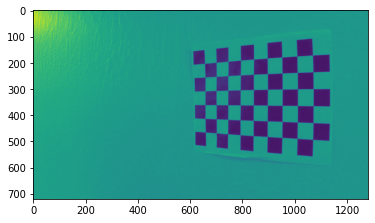

In [13]:
import numpy as np
import cv2
import glob
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    plt.imshow(gray)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

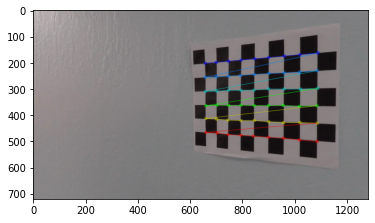

In [14]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undist)

In [15]:
# images = glob.glob('./test_images/*.jpg')
images = [cv2.imread(file) for file in glob.glob("./test_images/*.jpg")]

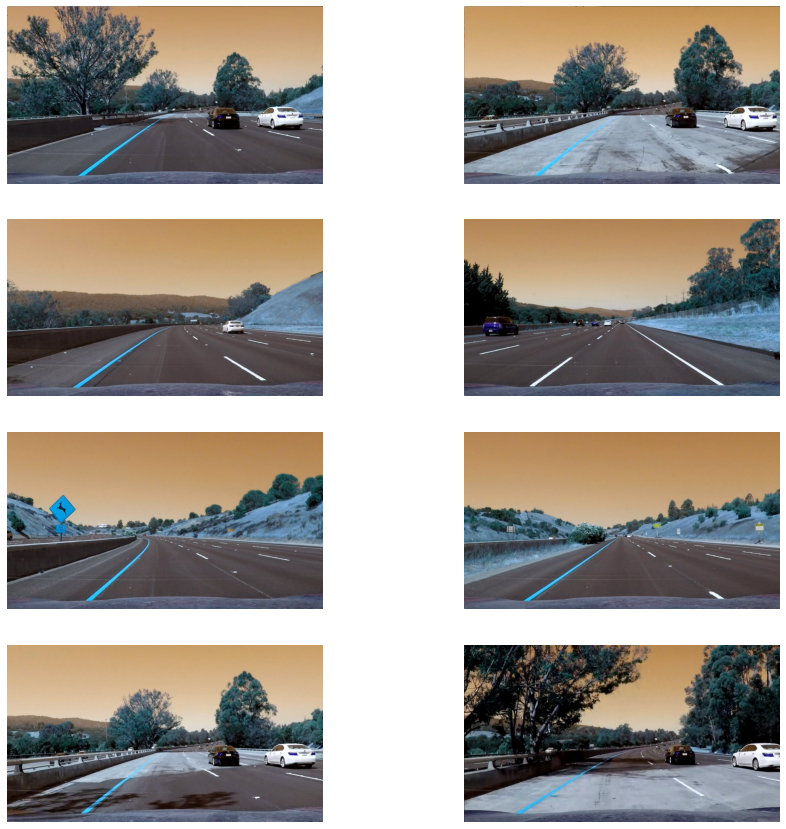

In [16]:
def showImages(images):
    fig, axes = plt.subplots(4, 2, figsize=(15, 15))
    indexes = range(8)
    for ax, image in zip(axes.flat, images):
        ax.imshow(image, cmap='gray')
        ax.axis('off')
showImages(images)

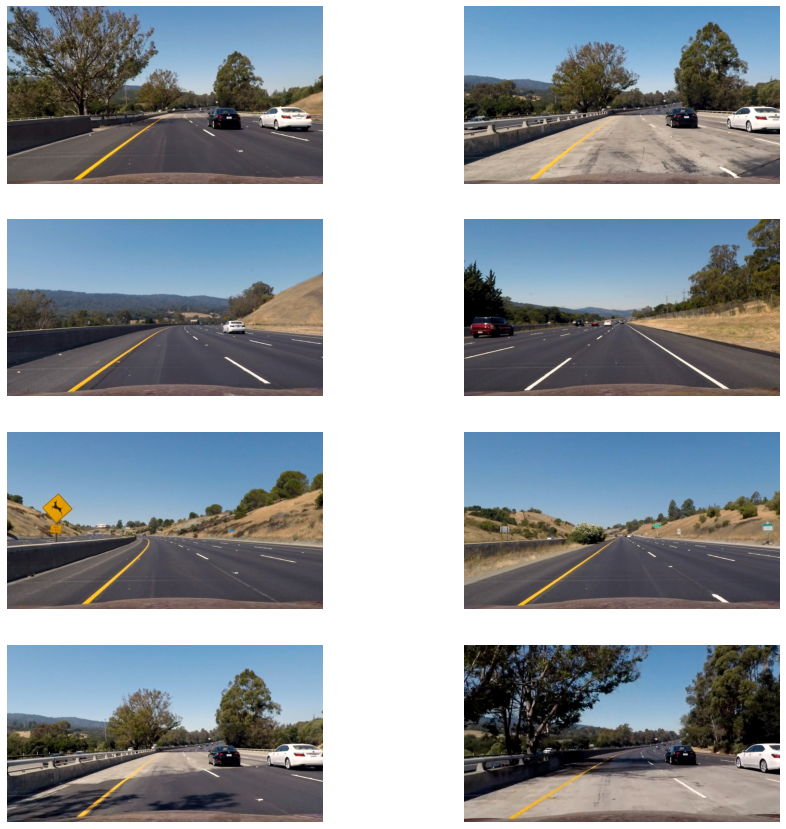

In [17]:
def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist
undist_images = []
for image in images:
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    undist_images.append(undistort(img))
showImages(undist_images)

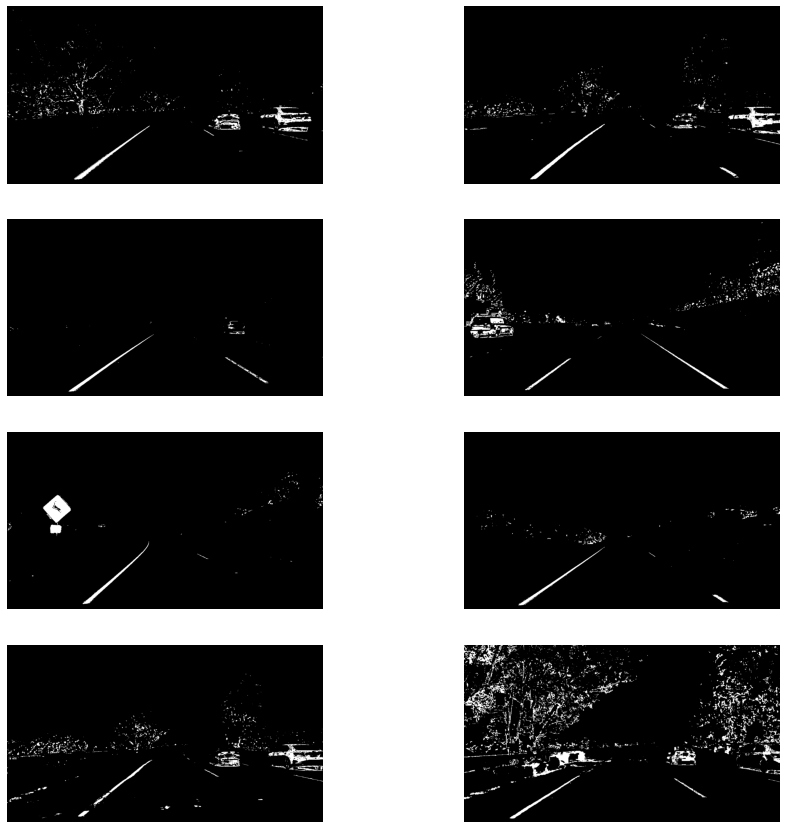

In [18]:
def sChannel(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    hls_binary_output = np.zeros_like(s_channel)
    hls_binary_output[(s_channel > 170) & (s_channel <= 255)] = 1
    return hls_binary_output
sChannel_images = []
for image in images:
    undist = undistort(image)
    sChannel_images.append(sChannel(undist))
showImages(sChannel_images)

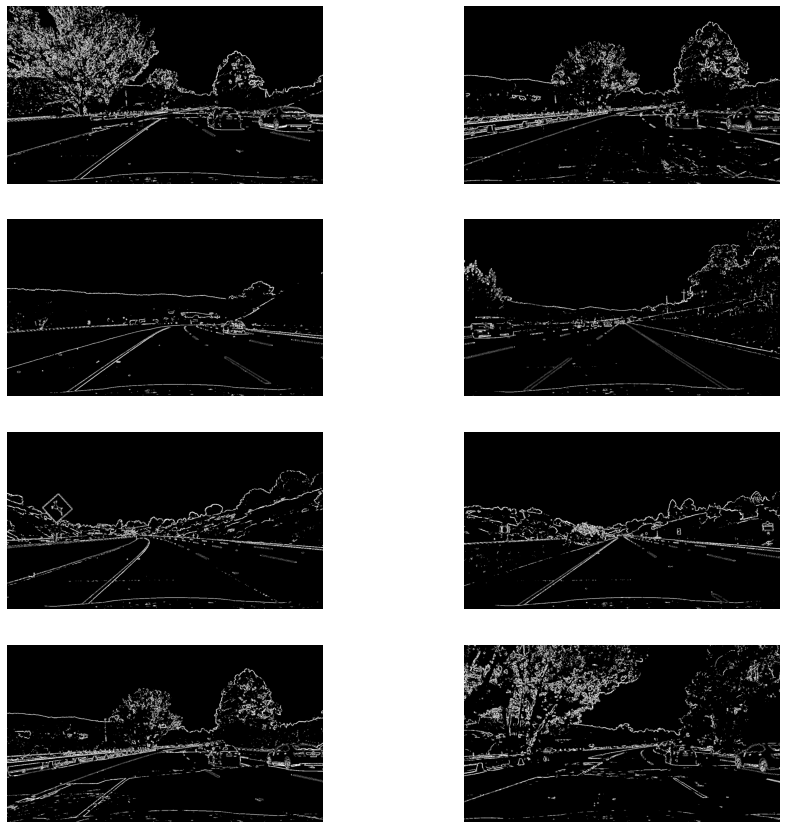

In [19]:
def Sobel(image):
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= 40) & (gradmag <= 100)] = 1
    return binary_output
sobel_images = []
for image in images:
    undist = undistort(image)
    sobel_images.append(Sobel(undist))
showImages(sobel_images)

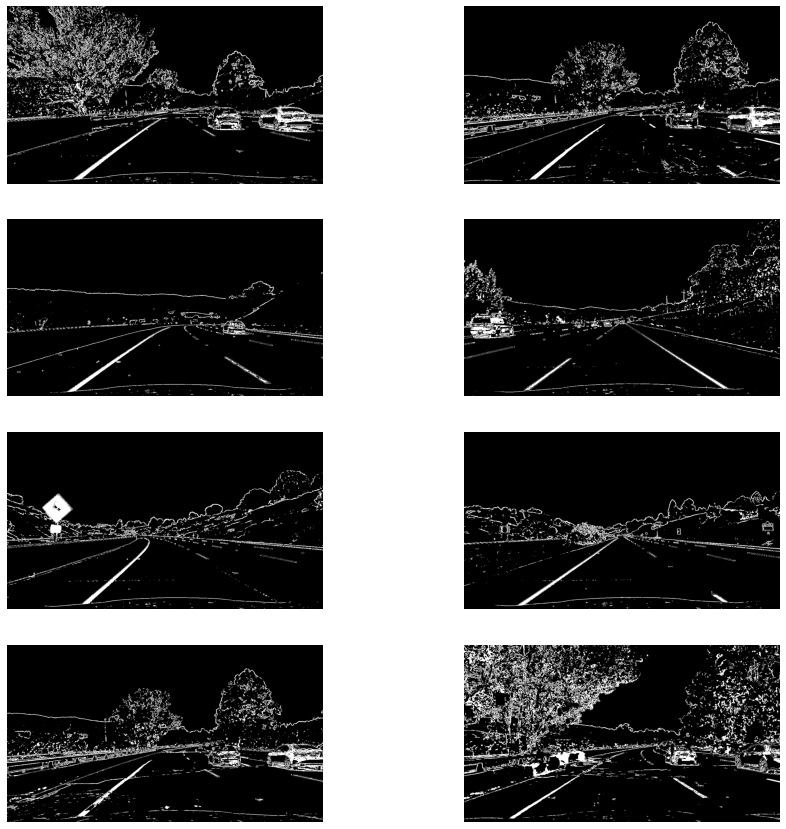

In [20]:
def Combined(image):
    sChannel_image = sChannel(image)
    sobel_image = Sobel(image)
    color_binary = np.dstack(( np.zeros_like(sobel_image), sobel_image, sChannel_image)) * 255
    combined_binary = np.zeros_like(sobel_image)
    combined_binary[(sobel_image == 1) | (sChannel_image == 1)] = 1
    return combined_binary
combined_images = []
for image in images:
    undist = undistort(image)
    combined_images.append(Combined(undist))
showImages(combined_images)

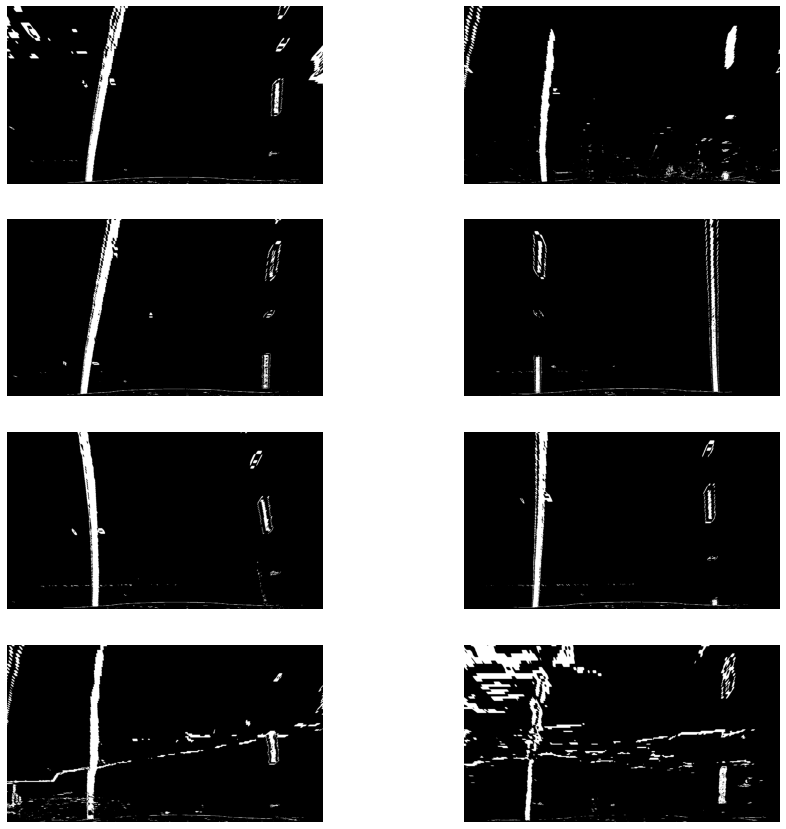

In [21]:
def PerspectiveTransform(image):
    img_size = (image.shape[1], image.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    return warped
warped_images = []
src = np.float32([[  100.,   719.],
                      [  542.,   470.],
                      [  738.,   470.],
                      [ 1180.,   719.]])
dst = np.float32([[ 200.,  720.],
                      [ 200.,    0.],
                      [ 1080.,    0.],
                      [ 1080.,  720.]])
for image in images:
    undist = undistort(image)
    warped = PerspectiveTransform(Combined(undist))
    warped_images.append(warped)
showImages(warped_images)

In [22]:
def lane_sanity_check(left_fitx, right_fitx, ploty):
    '''
    1. checking that they have similar curvature margin 10%
    2. checking that they are separated by approximately right distance horizontally
    tranform calibration distence 1280/2 margin 640, 5%(610-670) is good search, 15%(545-730) is detected
    3. Checking that they are roughly parallel, check the another side if 1280/4 margin 10%
    '''
    flag = True
    lane_distance_bot = right_fitx[720] - left_fitx[720]
    lane_distance_mid = right_fitx[320] - left_fitx[320]
    lane_distance_top = right_fitx[0] - left_fitx[0]

    # tranform calibration distence 1280/2 is 640, 5%(610-670) is good search, 15%(545-730) is detected
    if ((lane_distance_bot < 545) or (lane_distance_bot > 730)): flag = False
    if ((lane_distance_mid < 545) or (lane_distance_mid > 730)): flag = False
    if ((lane_distance_top < 500) or (lane_distance_top > 730)): flag = False # change top to 500, in some frame, the road in not flat, the lane will be small far from camera

    return flag, lane_distance_bot, lane_distance_mid, lane_distance_top

In [23]:
def fit_polynomial(leftx, lefty, rightx, righty, img_size):
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, img_size[0]-1, img_size[0] )
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fitx, right_fitx, ploty

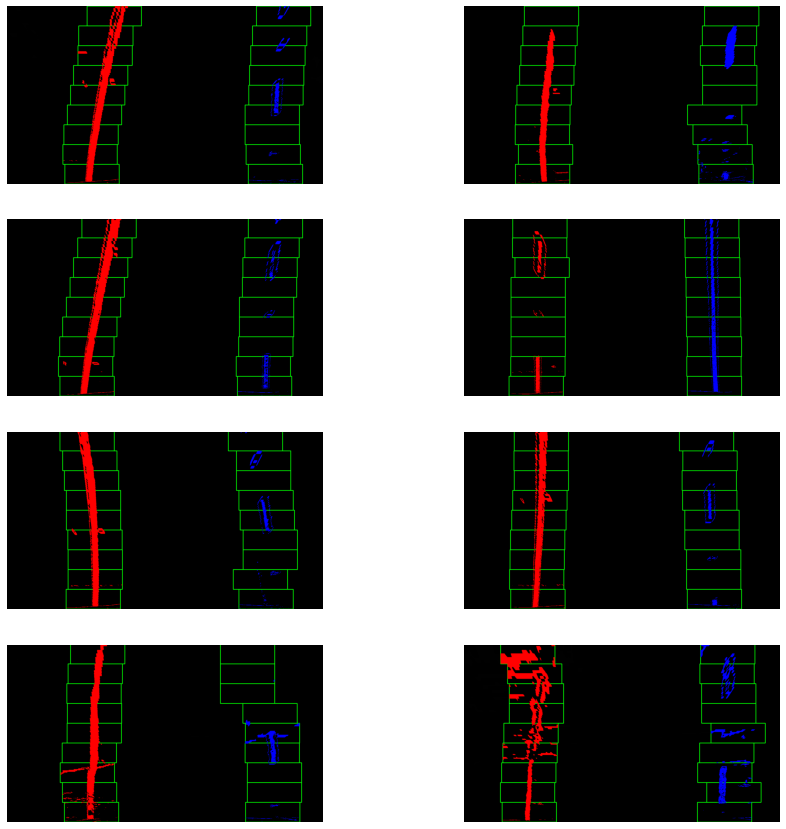

In [29]:
def findLanes(warped, nwindows=9, margin=110, minpix=50):
    bottom_half = warped[img.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)
    out_img = np.dstack((warped, warped, warped))
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    window_height = np.int(warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
       
        # Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
      
        # If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    return out_img, leftx, lefty, rightx, righty

lane_images = []
for warped in warped_images:
    out_img, leftx, lefty, rightx, righty = findLanes(warped)
    lane_images.append(out_img)
showImages(lane_images)

In [42]:
def Curvature(warped):
    ym_per_pix = 15/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/1280 # meters per pixel in x dimension
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    out_img, leftx, lefty, rightx, righty = findLanes(warped)
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad

for warped in warped_images:
    left_radius, right_radius = Curvature(warped)
    print('Left : {:.2f} m, Right : {:.2f} m'.format(left_radius, right_radius))

Left : 1606.80 m, Right : 1627.97 m
Left : 584.48 m, Right : 292.95 m
Left : 1517.25 m, Right : 990.02 m
Left : 2038.75 m, Right : 2047.00 m
Left : 1304.13 m, Right : 419.59 m
Left : 1519.43 m, Right : 609.49 m
Left : 1988.45 m, Right : 534.98 m
Left : 473.02 m, Right : 522.96 m


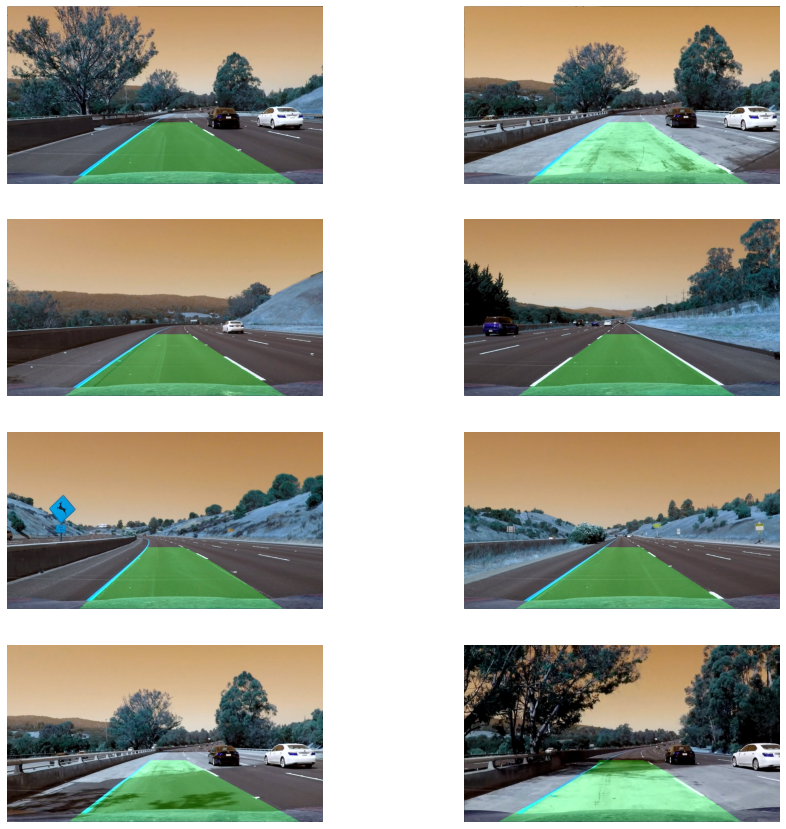

In [43]:
def drawLane(warped, img, left_fitx, right_fitx, ploty):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the blank back to original image space using inverse perspective matrix(Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

result_images = []
for i in range(8):
    img_size = (images[i].shape[1], images[i].shape[0])
    out_img, leftx, lefty, rightx, righty = findLanes(warped_images[i])
    left_fitx, right_fitx, ploty = fit_polynomial(leftx, lefty, rightx, righty, img_size)
    result_images.append(drawLane(warped_images[i], images[i], left_fitx, right_fitx, ploty))
showImages(result_images)

In [44]:
def measureOffset(lefty, leftx, righty, rightx):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    lineLeft = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
    lineRight = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = lineMiddle - vehicleCenter
    return diffFromVehicle

In [46]:
from moviepy.editor import VideoFileClip

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        # coeffients of the last n fits of the line
        self.recent_coefficients = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = [] 
        #y values for detected line pixels
        self.ally = []


def videoPipeline(inputVideo, outputVideo):
    myclip = VideoFileClip(inputVideo)
    
    left = Line()
    right = Line()
    
    def processImage(img):
        img_size = (img.shape[1], img.shape[0])
        undist = undistort(img)
        combined = Combined(undist)
        warped = PerspectiveTransform(combined)
        out_img, leftx, lefty, rightx, righty = findLanes(warped)
        if leftx.size == 0 or rightx.size == 0:
            leftx = left.allx[-1]
            lefty = left.ally[-1]
            rightx = right.allx[-1]
            righty = right.ally[-1]
        else:
            left.allx.append(leftx)
            left.ally.append(lefty)
            right.allx.append(rightx)
            right.ally.append(righty)
            
        left_fitx, right_fitx, ploty = fit_polynomial(leftx, lefty, rightx, righty, img_size)
        
        
        diffFromVehicle = measureOffset(lefty, leftx, righty, rightx)

        flag, lane_distance_bot, lane_distance_mid, lane_distance_top = lane_sanity_check(left_fitx, right_fitx, ploty)
        if flag:
            left.recent_xfitted.append(left_fitx)
            right.recent_xfitted.append(right_fitx)
        else:
            left_fitx = left.recent_xfitted[-1]
            right_fitx = right.recent_xfitted[-1]
            leftx = left.allx[-1]
            lefty = left.ally[-1]
            rightx = right.allx[-1]
            righty = right.ally[-1]
        left_curverad, right_curverad = Curvature(warped)
        curvature = (left_curverad + right_curverad)/2
        if diffFromVehicle > 0:
            offset = '{:.2f} m right'.format(diffFromVehicle)
        else:
            offset = '{:.2f} m left'.format(-diffFromVehicle)
        
        result = drawLane(warped, img, left_fitx, right_fitx, ploty)
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontColor = (255, 255, 255)
        cv2.putText(result, 'Curvature: {:.0f} m'.format(curvature), (50, 50), font, 1, fontColor, 2)
        cv2.putText(result, 'Vehicle is {} of center'.format(offset), (50, 190), font, 1, fontColor, 2)
        
        return result
    clip = myclip.fl_image(processImage)
    clip.write_videofile(outputVideo, audio=False)
    
# Project video
videoPipeline('project_video.mp4', 'video_output/project_video.mp4')

t:   0%|          | 2/1260 [00:00<01:29, 14.02it/s, now=None]

Moviepy - Building video video_output/project_video.mp4.
Moviepy - Writing video video_output/project_video.mp4



Moviepy - Done !
Moviepy - video ready video_output/project_video.mp4
